In [58]:
import pandas as pd
import numpy as np
import datetime
import pyodbc
isdw = pyodbc.connect('DSN=ISDW')
qdat = pyodbc.connect('DSN=QDAT')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.formula.api as sm


from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [2]:
# SQL Query for the metrology parms

daysback = 500

SQLQuery = """
WITH metrology_CTE AS (
  SELECT LEFT(lot_Id,11) AS lot_id_base, lot_id, wafer_id, family_Code,
    meas_Pd_Id || ' ' || dcItem_Name as parameter,
    MAX(measurement_date) AS date, COUNT(dcItem_Value) AS n_waf_in_lot,
    --STDDEV(dcItem_Value) AS stdDev,
    --MAX(mw.measuredWaferKey) AS dmiwKey 
    AVG(dcItem_Value) AS mean
  FROM DMIW.MeasuredRawFact mrf
  INNER JOIN DMIW_SYSTEMS.MeasuredParm mp ON mp.measuredParmKey = mrf.measuredParmKey
  INNER JOIN DMIW_SYSTEMS.MeasuredWafer mw ON mw.measuredWaferKey = mrf. measuredWaferKey
  WHERE
    mw.Measurement_date >= (current date - {} days) and
    mw.Tech_id = '5H 14HP' and mw.Meas_pd_id in ('MEACDRIE5CTP.1', 'MEACDWCMP5NGP.1') and
    mw.meas_Pd_Id <> '' and dcItem_Value is not null and 
    ucase(dcItem_Name) not in ('XCOORD', 'YCOORD', 'XSITE', 'YSITE', 'FIELD X', 'FIELD Y', 'SITE X', 'SITE Y', 'SITEID', 'ROW', 'COLUMN') 
    and (( ucase(rtrim(meas_Pd_Id) || ' ' || dcItem_Name) like 'MEACDWCMP5NGP.1%G01%P15%' )
    or  ( ucase(rtrim(meas_Pd_Id) || ' ' || dcItem_Name) like 'MEACDRIE5CTP.1%G01%P23%' ))
  GROUP BY lot_Id, wafer_Id, family_Code, meas_pd_Id, dcItem_Name
)

SELECT lot_id_base as F10_LotBase, lot_id as F10_LotID, wafer_id, family_code,
  SUM(case parameter
      WHEN 'MEACDWCMP5NGP.1 G01 P15DieSiteValue'
      THEN mean
      ELSE 0
  END) AS parm1,
  SUM(CASE parameter
      WHEN 'MEACDRIE5CTP.1 G01 P23DieSiteValue'
      THEN mean
      ELSE 0
  END) AS parm2
FROM metrology_CTE
GROUP BY Lot_id_base, lot_id, WAFER_ID, family_code
""".format(daysback)
met_df = pd.read_sql(SQLQuery,isdw)

# Note PARM2 is sampled whereas PARM1 is not

In [3]:
# Fill in all the empty measurements and calculate the gate expansion proxy.
met_df.PARM1 = met_df.PARM1.apply(lambda x: None if x == 0 else x)
met_df.PARM2 = met_df.PARM2.apply(lambda x: None if x == 0 else x)
met_df['gate_expansion'] = met_df.PARM1 - met_df.PARM2

In [4]:
met_df

,F10_LOTBASE,F10_LOTID,WAFER_ID,FAMILY_CODE,PARM1,PARM2,gate_expansion
0,18375H9S015,18375H9S015.004,65700N7SSEC5,9S,NaN,214.358905,NaN
1,18485H9S007,18485H9S007.000,65700NAYSEG6,9S,252.473059,213.403762,39.069297
2,18485H9S006,18485H9S006.000,65700W0ASEE6,9S,239.025118,200.050952,38.974165
3,18485H9S006,18485H9S006.000,65700W0GSEA6,9S,249.823412,204.785571,45.037840
4,18405H9S014,18405H9S014.000,65700W7ESEB5,9S,223.637412,NaN,NaN
...,...,...,...,...,...,...,...
22046,19485HUS013,19485HUS013.000,6A09I263SOC4,US,NaN,212.964333,NaN
22047,19495HUS008,19495HUS008.000,6A09K156SOF0,US,NaN,212.087381,NaN
22048,19495HUS011,19495HUS011.000,6A09L176SOH0,US,NaN,201.028143,NaN
22049,19515HUS001,19515HUS001.000,6A09M148SOC3,US,NaN,203.576952,NaN


In [5]:
# SQL Query for ILT Parms
daysback = 500

SQLQuery = """
WITH ilt_cte AS(
  SELECT LEFT(lot_id,9) as lot_id_base, lot_id, wafer_id, family_code, tw.last_TestTimeStamp as date, tw.testProgramName as step, 
    last_Eqp_Id as tool, parm_Label as parameter, weighted_Mean as mean, tw.testedWaferKey as dmiwKey
  FROM DMIW.PTileWaferFact pwf
  INNER JOIN DMIW_SYSTEMS.TestParm tp ON tp.testParmKey = pwf.testParmKey
  INNER JOIN DMIW_SYSTEMS.TestedWafer tw ON tw.testedWaferKey = pwf.testedWaferKey
  WHERE
    tw.Last_test_date >= (current date - {} days) and tw.Tech_id = '5H 14HP' and tw.Level = 'FV' and
    (tw.Calcdefs like 'KXAM%' or tw.Calcdefs LIKE 'AXAA%') 
    and weighted_Mean is not null and abs(weighted_Mean) < 1e25
    and ( ucase(tp.parm_Label) in ('SLK_ESPIN_HVT_PFET_FV_RON', 'STM_SGP_LVT_L20_FV_CGON'))
  ORDER BY lot_Id, wafer_Id, parm_Label, level
)

SELECT lot_id_base AS F8_LotBase, lot_id AS F8_LotID, wafer_id, 
  --step, tool, parameter, dmiwKey, date, family_code,
  MAX(CASE parameter 
       WHEN 'SLK_ESPIN_HVT_PFET_FV_Ron'
       THEN mean
       ELSE 0
  END) AS hvt_Ron,
  MAX(CASE parameter
       WHEN 'StM_SGP_LVT_L20_FV_Cgon'
       THEN mean
       ELSE 0
  END) AS lvt_Cgon
FROM ilt_cte
GROUP BY lot_id_base, lot_id, wafer_id, family_code, date
""".format(daysback)
ilt_df = pd.read_sql(SQLQuery,isdw)

In [6]:
ilt_df.HVT_RON = ilt_df.HVT_RON.apply(lambda x: None if x == 0 else x)
ilt_df.LVT_CGON = ilt_df.LVT_CGON.apply(lambda x: None if x == 0 else x)

In [7]:
ilt_df

,F8_LOTBASE,F8_LOTID,WAFER_ID,HVT_RON,LVT_CGON
0,8IQT37011,8IQT37011.000,6A06N021SOA1,507.211243,79.920982
1,8IQT35000,8IQT35000.000,65700G02SEG5,506.604797,78.921509
2,8IQT37016,8IQT37016.000,65700J66SED6,518.227356,78.774216
3,8IQT35007,8IQT35007.000,6A06L092SOF5,519.263306,76.833290
4,8IQT35001,8IQT35001.000,6A06G026SOE0,497.437164,80.752182
...,...,...,...,...,...
21910,8IQV06005,8IQV06005.000,65800B2BSEB3,562.296204,77.255013
21911,8IQV06017,8IQV06017.000,6A096161SOC4,578.838135,74.218002
21912,8IQV05009,8IQV05009.000,65800B1USED7,583.966919,75.787354
21913,8IQV05004,8IQV05004.000,6A095339SOG1,540.633911,71.725662


In [8]:
daysback = 300

SQLQuery = """
SELECT wafer_id, sail_delta_vmin, Lagrange_8_24c, LOT_GROUP,
  CASE QT_SICONI_BHF_GRP 
       WHEN 'short'
       THEN 1
       ELSE 0
  END AS QT_SICONI_BHF_GRP_short, 
  CASE QT_BHF_EG_GRP
       WHEN 'short'
       THEN 1
       ElSE 0
  END AS QT_BHF_EG_GRP_short,
  CASE QT_EG_GRP
       WHEN 'short-short'
       THEN 1
       ELSE 0
  END AS QT_EG_GRP_shortshort
FROM P9.eg_qt_data
--fetch first 100 rows only
""".format(daysback)
jon_df = pd.read_sql(SQLQuery,qdat)

In [29]:
temp = pd.merge(met_df, ilt_df, on='WAFER_ID', how='inner')
df = pd.merge(temp, jon_df, on='WAFER_ID', how = 'inner')

In [30]:
df = df.dropna()

In [31]:
df

,F10_LOTBASE,F10_LOTID,WAFER_ID,FAMILY_CODE,PARM1,PARM2,gate_expansion,F8_LOTBASE,F8_LOTID,HVT_RON,LVT_CGON,SAIL_DELTA_VMIN,LAGRANGE_8_24C,LOT_GROUP,QT_SICONI_BHF_GRP_SHORT,QT_BHF_EG_GRP_SHORT,QT_EG_GRP_SHORTSHORT
0,18485H9S007,18485H9S007.000,65700NAYSEG6,9S,252.473059,213.403762,39.069297,8IQU18012,8IQU18012.000,561.279968,78.312027,0.000000e+00,0.265625,G15_Baseline,0,1,0
1,18485H9S006,18485H9S006.000,65700W0ASEE6,9S,239.025118,200.050952,38.974165,8IQU20003,8IQU20003.000,513.054260,73.437927,2.564102e-02,0.328125,G15_Baseline,1,0,0
2,18485H9S006,18485H9S006.000,65700W0GSEA6,9S,249.823412,204.785571,45.037840,8IQU20003,8IQU20003.000,521.760986,78.335571,0.000000e+00,0.375000,G15_Baseline,0,0,0
12,18375H9S013,18375H9S013.000,6A077128SOB2,9S,244.032000,204.083238,39.948762,8IQU04000,8IQU04000.000,605.399780,73.700912,6.942777e-310,0.312500,G15_Baseline,1,0,0
19,19035H9S011,19035H9S011.000,6A07M251SOH1,9S,239.271824,211.145524,28.126300,8IQU40000,8IQU40000.000,529.871765,74.273544,0.000000e+00,0.203125,G15_Baseline,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16089,19275HUS001,19275HUS001.000,6A093161SOB3,US,271.358824,216.068333,55.290490,8IQU50018,8IQU50018.000,537.582031,81.497032,6.942777e-310,0.343750,G15_Baseline,0,0,0
16099,19245HUS006,19245HUS006.000,6A08X065SOA5,US,250.145824,207.378571,42.767252,8IQU49011,8IQU49011.000,525.454102,78.248314,6.942775e-310,0.296875,G15_Baseline,0,0,0
16101,19295HUS010,19295HUS010.000,6A08Y274SOG7,US,253.669294,205.369810,48.299485,8IQV01012,8IQV01012.000,541.544189,78.853493,2.564102e-02,0.250000,G15_Baseline,0,1,0
16102,19265HUS007,19265HUS007.000,6A08Y385SOA0,US,267.993059,208.108095,59.884964,8IQU50008,8IQU50008.000,531.861633,80.450569,6.942777e-310,0.343750,G15_Baseline,1,0,0


In [12]:
baseline = df[df.LOT_GROUP == 'G15_Baseline']

In [13]:
baseline

,F10_LOTBASE,F10_LOTID,WAFER_ID,FAMILY_CODE,PARM1,PARM2,gate_expansion,F8_LOTBASE,F8_LOTID,HVT_RON,LVT_CGON,SAIL_DELTA_VMIN,LAGRANGE_8_24C,LOT_GROUP,QT_SICONI_BHF_GRP_SHORT,QT_BHF_EG_GRP_SHORT,QT_EG_GRP_SHORTSHORT
0,18485H9S007,18485H9S007.000,65700NAYSEG6,9S,252.473059,213.403762,39.069297,8IQU18012,8IQU18012.000,561.279968,78.312027,0.000000e+00,0.265625,G15_Baseline,0,1,0
1,18485H9S006,18485H9S006.000,65700W0ASEE6,9S,239.025118,200.050952,38.974165,8IQU20003,8IQU20003.000,513.054260,73.437927,2.564102e-02,0.328125,G15_Baseline,1,0,0
2,18485H9S006,18485H9S006.000,65700W0GSEA6,9S,249.823412,204.785571,45.037840,8IQU20003,8IQU20003.000,521.760986,78.335571,0.000000e+00,0.375000,G15_Baseline,0,0,0
12,18375H9S013,18375H9S013.000,6A077128SOB2,9S,244.032000,204.083238,39.948762,8IQU04000,8IQU04000.000,605.399780,73.700912,6.942777e-310,0.312500,G15_Baseline,1,0,0
19,19035H9S011,19035H9S011.000,6A07M251SOH1,9S,239.271824,211.145524,28.126300,8IQU40000,8IQU40000.000,529.871765,74.273544,0.000000e+00,0.203125,G15_Baseline,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16089,19275HUS001,19275HUS001.000,6A093161SOB3,US,271.358824,216.068333,55.290490,8IQU50018,8IQU50018.000,537.582031,81.497032,6.942777e-310,0.343750,G15_Baseline,0,0,0
16099,19245HUS006,19245HUS006.000,6A08X065SOA5,US,250.145824,207.378571,42.767252,8IQU49011,8IQU49011.000,525.454102,78.248314,6.942775e-310,0.296875,G15_Baseline,0,0,0
16101,19295HUS010,19295HUS010.000,6A08Y274SOG7,US,253.669294,205.369810,48.299485,8IQV01012,8IQV01012.000,541.544189,78.853493,2.564102e-02,0.250000,G15_Baseline,0,1,0
16102,19265HUS007,19265HUS007.000,6A08Y385SOA0,US,267.993059,208.108095,59.884964,8IQU50008,8IQU50008.000,531.861633,80.450569,6.942777e-310,0.343750,G15_Baseline,1,0,0


In [33]:
df.to_csv("~/Downloads/data.csv")

In [14]:
y = ['LAGRANGE_8_24C','SAIL_DELTA_VMIN']
parameters = ['gate_expansion','HVT_RON','LVT_CGON','QT_SICONI_BHF_GRP_SHORT','QT_BHF_EG_GRP_SHORT']

In [16]:
def olsSummary(y,parameters,data):
    fcn = y+'~'

    for i in parameters:
        if data[i].any():
            fcn += i +'+'
    fcn = fcn[:-1]
    lm = sm.ols(fcn,data=data).fit(cov_type="cluster", cov_kwds={'groups':data["F8_LOTBASE"]})
    print(lm.summary())

In [17]:
olsSummary(y[0],parameters,baseline)

                            OLS Regression Results                            
Dep. Variable:         LAGRANGE_8_24C   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     2.786
Date:                Tue, 24 Mar 2020   Prob (F-statistic):             0.0175
Time:                        15:22:15   Log-Likelihood:                 1006.4
No. Observations:                1608   AIC:                            -2001.
Df Residuals:                    1602   BIC:                            -1969.
Df Model:                           5                                         
Covariance Type:              cluster                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [32]:
df['PEEO'] = df.SAIL_DELTA_VMIN.apply(lambda x: 1 if x >= 0.05 else 0)

In [55]:
training = df.set_index(['F8_LOTBASE','WAFER_ID','FAMILY_CODE'])
training_x = training[['gate_expansion','HVT_RON','LVT_CGON','QT_SICONI_BHF_GRP_SHORT','QT_BHF_EG_GRP_SHORT']]
training_y = training['PEEO']

In [56]:
clf = ensemble.RandomForestClassifier(n_jobs=-1)

# Gridsearch CV
parameter_grid = {'max_depth' : np.arange(5,12,1),
                  'n_estimators' : np.arange(200,250,10),
                  'criterion' : ['gini', 'entropy'],
                  'class_weight' : [None, 'balanced']
                 }

grid_search = model_selection.GridSearchCV(clf,parameter_grid)
grid_search.fit(training_x,training_y)
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

average accuracy score: 0.9189469214437368


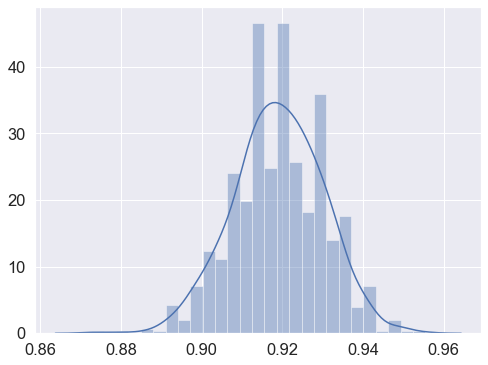

In [59]:
# Model Accuracy
# take the best model from the grid search and split it randomly x times to test for the accuracy
clf = grid_search.best_estimator_
cv = model_selection.ShuffleSplit(n_splits=1000, test_size=0.2)
cv_scores = model_selection.cross_val_score(clf, training_x, training_y, cv=cv)

# plot out the distribution of shufflesplit to get performance estimate
plt.figure(figsize=(8,6))
sns.set(font_scale=1.5)
sns.distributions.distplot(tuple(cv_scores))
print("average accuracy score:", cv_scores.mean())

In [61]:
# Quick Model RandomForestClassifier
model = ensemble.RandomForestClassifier(class_weight=None, criterion='gini',
                                            max_depth=5, n_estimators=200, n_jobs=-1)
model.fit(training_x, training_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [62]:
baseline = baseline.set_index(['F8_LOTBASE','WAFER_ID','FAMILY_CODE'])
baseline_x = baseline[['gate_expansion','HVT_RON','LVT_CGON','QT_SICONI_BHF_GRP_SHORT','QT_BHF_EG_GRP_SHORT']]

In [72]:
baseline['predict_proba'] = [i[1] for i in model.predict_proba(X=baseline_x)]

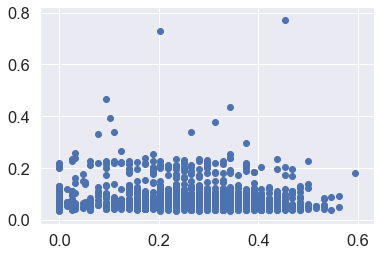

In [75]:
plt.scatter(baseline.LAGRANGE_8_24C,baseline.predict_proba)

In [76]:
baseline.to_csv('~/Downloads/temp.csv')